In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***# Step1: Load & Explore data***

In [2]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thống kê/train.csv")

#Khám phá ban đầu: Kiểm tra kiểu dữ liệu và giá trị thiếu (null)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243787 entries, 0 to 243786
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   AccountAge                243787 non-null  int64  
 1   MonthlyCharges            243787 non-null  float64
 2   TotalCharges              243787 non-null  float64
 3   SubscriptionType          243787 non-null  object 
 4   PaymentMethod             243787 non-null  object 
 5   PaperlessBilling          243787 non-null  object 
 6   ContentType               243787 non-null  object 
 7   MultiDeviceAccess         243787 non-null  object 
 8   DeviceRegistered          243787 non-null  object 
 9   ViewingHoursPerWeek       243787 non-null  float64
 10  AverageViewingDuration    243787 non-null  float64
 11  ContentDownloadsPerMonth  243787 non-null  int64  
 12  GenrePreference           243787 non-null  object 
 13  UserRating                243787 non-null  f

In [3]:
df.describe()

,AccountAge,MonthlyCharges,TotalCharges,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,UserRating,SupportTicketsPerMonth,WatchlistSize,Churn
count,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000
mean,60.083758,12.490695,750.741017,20.502179,92.264061,24.503513,3.002713,4.504186,12.018508,0.181232
std,34.285143,4.327615,523.073273,11.243753,50.505243,14.421174,1.155259,2.872548,7.193034,0.385211
min,1.000000,4.990062,4.991154,1.000065,5.000547,0.000000,1.000007,0.000000,0.000000,0.000000
25%,30.000000,8.738543,329.147027,10.763953,48.382395,12.000000,2.000853,2.000000,6.000000,0.000000
50%,60.000000,12.495555,649.878487,20.523116,92.249992,24.000000,3.002261,4.000000,12.000000,0.000000
75%,90.000000,16.238160,1089.317362,30.219396,135.908048,37.000000,4.002157,7.000000,18.000000,0.000000
max,119.000000,19.989957,2378.723844,39.999723,179.999275,49.000000,4.999989,9.000000,24.000000,1.000000


In [4]:
print("\n--- Phân bổ của biến mục tiêu 'Churn' (Tỷ lệ %) ---")
#normalize=True để xem tỉ lệ %
churn_distribution = df['Churn'].value_counts(normalize=True) * 100
print(churn_distribution)



--- Phân bổ của biến mục tiêu 'Churn' (Tỷ lệ %) ---
Churn
0    81.876802
1    18.123198
Name: proportion, dtype: float64


Đây là một T_T (tập dữ liệu) mất cân bằng. Điều này rất quan trọng. Nó có nghĩa là nếu mô hình chỉ đoán "Không Churn" cho tất cả mọi người, nó vẫn đạt độ chính xác ~82%.

Vì vậy, khi đánh giá mô hình, chúng ta không thể chỉ dựa vào Accuracy (Độ chính xác). Chúng ta phải tập trung vào Precision, Recall, F1-Score (đặc biệt là cho lớp 1) và ROC-AUC.

# Bước 2 (Tiền xử lý) và Bước 3 (Phân chia Dữ liệu).
Chuẩn bị (Bước 2): Xác định X (features) và y (target), đồng thời phân loại các cột X thành 2 nhóm: số (numerical) và phân loại (categorical).

Phân chia (Bước 3): Chia X và y thành T_T (tập dữ liệu) huấn luyện và kiểm thử.*italicised text*

Áp dụng (Bước 2): Áp dụng các kỹ thuật tiền xử lý (Scaling và Encoding) cho các T_T đã chia.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Tiền xử lí dữ liệu
#Loại bỏ cột không cần thiết: CustomerID vì chỉ mang ý nghĩa định danh.
X = df.drop('CustomerID', axis=1)
X = X.drop('Churn', axis=1)
y = df['Churn']

# Encode Yes/No
binary_cols = ['PaperlessBilling', 'MultiDeviceAccess', 'ParentalControl', 'SubtitlesEnabled']
for col in binary_cols:
    X[col] = X[col].map({'Yes': 1, 'No': 0})


#Phân loại cột X thành 2 nhóm: số (numerical) và phân loại (categorical)
#Cột số (numerical)
numerical_cols = ['AccountAge', 'MonthlyCharges', 'TotalCharges', 'ViewingHoursPerWeek',
                'AverageViewingDuration', 'ContentDownloadsPerMonth', 'UserRating',
                'SupportTicketsPerMonth', 'WatchlistSize']
categorical_cols = ['SubscriptionType', 'PaymentMethod', 'ContentType', 'DeviceRegistered', 'GenrePreference', 'Gender']
print(f"Đã xác định {len(numerical_cols)} cột số (numerical).")
print(f"Đã xác định {len(categorical_cols)} cột phân loại (categorical).")


#B3. Phân chia dữ liệu
# Phân chia T_T (80% train, 20% test)
# Rất quan trọng: stratify=y để giữ nguyên tỷ lệ Churn (18%) trong cả 2 T_T

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2, #20% T_T test
    random_state=42,
    stratify=y
)
print(f"Kích thước T_T Huấn luyện (X_train): {X_train.shape}")
print(f"Kích thước T_T Kiểm thử (X_test):  {X_test.shape}")


#Pre-processing data:
#Chúng ta sẽ học bộ xử lí trên X_train, và 'transform' cho cả X_train và X_test
# 1. Tạo pipeline cho biến số (Chuẩn hóa)
# Dùng StandardScaler để đưa các cột số về cùng thang đo (đưa về phân phối chuẩn, mean=0, std=1)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 2. Tạo pipeline cho biến phân loại (Mã hóa One-Hot)
# Dùng OneHotEncoder để biến các cột phân loại (text) thành các cột nhị phân (0/1)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

#3. Kết hợp 2 pipeline bằng ColumnTransformer:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

# 4. Áp dụng preprocessor
# Fit (học) và transform (biến đổi) trên X_train
print("Đang fit_transform X_train...")
X_train_processed = preprocessor.fit_transform(X_train)
# Chỉ transform (biến đổi) trên X_test (dùng các tham số đã học từ X_train)
print("Đang transform X_test...")
X_test_processed = preprocessor.transform(X_test)

print(f"Kích thước X_train sau khi xử lý: {X_train_processed.shape}")
print(f"Kích thước X_test sau khi xử lý:  {X_test_processed.shape}")

Đã xác định 9 cột số (numerical).
Đã xác định 6 cột phân loại (categorical).
Kích thước T_T Huấn luyện (X_train): (195029, 19)
Kích thước T_T Kiểm thử (X_test):  (48758, 19)
Đang fit_transform X_train...
Đang transform X_test...
Kích thước X_train sau khi xử lý: (195029, 34)
Kích thước X_test sau khi xử lý:  (48758, 34)


Phân chia: T_T (tập dữ liệu) được chia thành 195,029 hàng huấn luyện và 48,758 hàng kiểm thử. Tỷ lệ Churn (18.12%) được giữ nguyên trong cả hai T_T.

Các cột số đã được chuẩn hóa (scaled).

Các cột phân loại đã được mã hóa One-Hot.

Số lượng cột (features) ban đầu là 20.

Sau khi One-Hot Encoding (biến 6 cột phân loại thành nhiều cột nhị phân), tổng số cột (features) đã tăng lên 35.

# Bước 4 & 5: Huấn luyện và Đánh giá Mô hình

1. Training: Khởi tạo Logistic Regression

Note: dùng class_weight="balanced" vì T_T mất cân bằng (18% churn). Điều này giúp tự động điều chỉnh mô hình, khiến mô hình quan tâm đến việc dự đoán đúng lớp thiểu số.




Bắt đầu huấn luyện mô hình...
Huấn luyện hoàn tất.
--- Confusion MATRIX ---
[[26947 12974]
 [ 2653  6184]]

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.91      0.68      0.78     39921
           1       0.32      0.70      0.44      8837

    accuracy                           0.68     48758
   macro avg       0.62      0.69      0.61     48758
weighted avg       0.80      0.68      0.71     48758


Điểm AUC-ROC: 0.7544

Accuracy: 0.6795


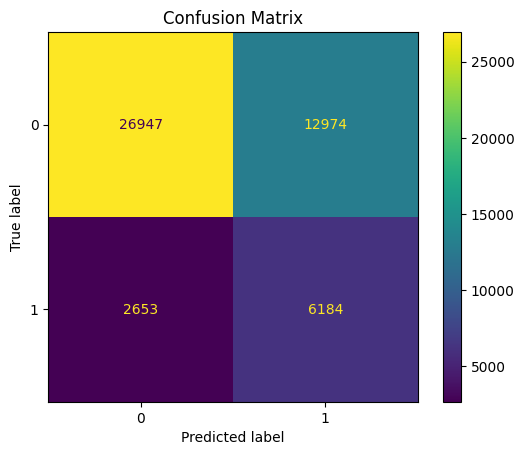

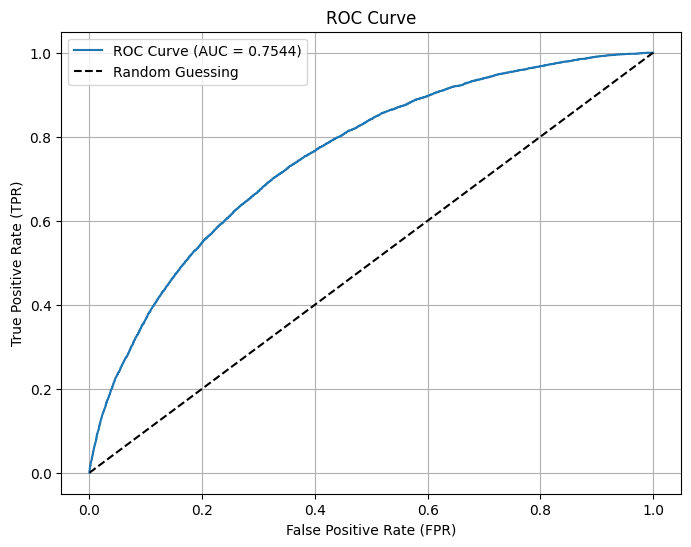

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    ConfusionMatrixDisplay,
    roc_curve # Import roc_curve
)
import matplotlib.pyplot as plt


# Khởi tạo mô hình Logistic Regression
log_reg_model = LogisticRegression(
    C=1.0,               # Tham số chính quy (Regularization strength)
    penalty='l2',        # Loại chính quy (L1, L2, Elasticnet)
    solver='liblinear',  # Thuật toán tối ưu hóa
    max_iter=1000,       # Số lần lặp tối đa
    random_state=42,
    class_weight='balanced' # Xử lý mất cân bằng lớp (rất nên dùng cho bài toán Churn)
)

print("Bắt đầu huấn luyện mô hình...")
log_reg_model.fit(X_train_processed, y_train)
print("Huấn luyện hoàn tất.")

# Dự đoán trên T_T kiểm thử
y_pred = log_reg_model.predict(X_test_processed)

# Lấy xác suất của lớp 1 (Churn)
y_prob = log_reg_model.predict_proba(X_test_processed)[:, 1]

print("--- Confusion MATRIX ---")
print(confusion_matrix(y_test, y_pred))

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Điểm AUC-ROC (Area Under the Receiver Operating Characteristic Curve)
auc_roc = roc_auc_score(y_test, y_prob)
print(f"\nĐiểm AUC-ROC: {auc_roc:.4f}")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Hiển thị Confusion Matrix trực quan hơn
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Vẽ biểu đồ ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing') # Dashed diagonal line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

### Tinh chỉnh Siêu tham số với GridSearchCV

Bắt đầu tinh chỉnh siêu tham số...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Tinh chỉnh hoàn tất.

Siêu tham số tốt nhất (Best Parameters):
{'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

Điểm đánh giá tốt nhất (Best Score - ROC AUC) trên CV folds:
0.6836285275376927

Đánh giá mô hình tốt nhất trên T_T kiểm thử:
              precision    recall  f1-score   support

           0       0.91      0.68      0.78     39921
           1       0.32      0.70      0.44      8837

    accuracy                           0.68     48758
   macro avg       0.62      0.69      0.61     48758
weighted avg       0.80      0.68      0.71     48758


ROC-AUC Score trên T_T kiểm thử: 0.7546


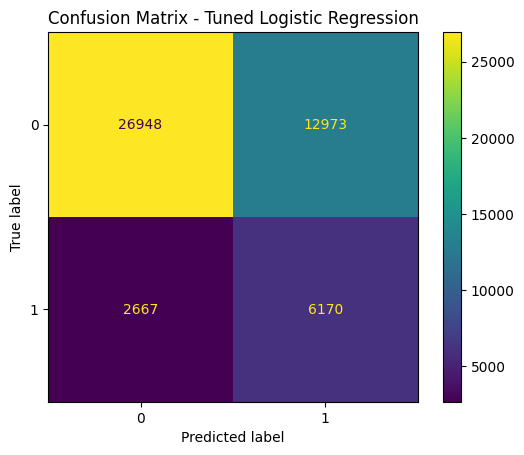

In [23]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer

# Định nghĩa lưới các siêu tham số cần tinh chỉnh
# Lưu ý: Chọn solver phù hợp với penalty
# 'liblinear' hỗ trợ 'l1' và 'l2'
# 'saga' hỗ trợ 'l1', 'l2', 'elasticnet', 'none'
# 'lbfgs', 'sag' hỗ trợ 'l2', 'none'

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], # Inverse of regularization strength
    'penalty': ['l1', 'l2'],           # Type of regularization
    'solver': ['liblinear'],           # Solvers that support l1 and l2
    'class_weight': ['balanced']       # Keep balanced class weight
}

# Tạo scorer dựa trên ROC AUC (hoặc F1-score cho lớp 1)
# make_scorer giúp chuyển đổi hàm đánh giá thành đối tượng scorer phù hợp cho GridSearchCV
roc_auc_scorer = make_scorer(roc_auc_score)
# f1_scorer = make_scorer(f1_score, pos_label=1) # Nếu muốn tối ưu F1 cho lớp 1

# Sử dụng StratifiedKFold để đảm bảo tỷ lệ lớp được giữ nguyên trong mỗi fold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Khởi tạo GridSearchCV
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000), # Pass the base estimator
    param_grid=param_grid,
    scoring=roc_auc_scorer, # Use the appropriate scoring metric
    cv=cv_strategy,         # Cross-validation strategy
    n_jobs=-1,              # Use all available CPU cores
    verbose=2               # Display progress
)

print("Bắt đầu tinh chỉnh siêu tham số...")
# Thực hiện tìm kiếm lưới trên dữ liệu huấn luyện đã tiền xử lý
grid_search.fit(X_train_processed, y_train)
print("Tinh chỉnh hoàn tất.")

# In ra các siêu tham số tốt nhất tìm được
print("\nSiêu tham số tốt nhất (Best Parameters):")
print(grid_search.best_params_)

# In ra điểm đánh giá tốt nhất (ví dụ: ROC AUC) trên các fold CV
print("\nĐiểm đánh giá tốt nhất (Best Score - ROC AUC) trên CV folds:")
print(grid_search.best_score_)

# Lấy mô hình tốt nhất đã được huấn luyện trên toàn bộ dữ liệu huấn luyện
best_log_reg_model = grid_search.best_estimator_

# Đánh giá mô hình tốt nhất trên tập kiểm thử độc lập
print("\nĐánh giá mô hình tốt nhất trên T_T kiểm thử:")
y_pred_tuned = best_log_reg_model.predict(X_test_processed)
y_prob_tuned = best_log_reg_model.predict_proba(X_test_processed)[:, 1]

print(classification_report(y_test, y_pred_tuned))
print(f"\nROC-AUC Score trên T_T kiểm thử: {roc_auc_score(y_test, y_prob_tuned):.4f}")

# Hiển thị Confusion Matrix cho mô hình tốt nhất
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
disp_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_tuned, display_labels=[0, 1])
disp_tuned.plot()
plt.title("Confusion Matrix - Tuned Logistic Regression")
plt.show()

AUC_ROC. = 0.7544 cho thấy cả hai mô hình đều có khả năng phân biệt giữa khách hàng Churn và không Churn tốt hơn ngẫu nhiên.

Ngưỡng Tối ưu hóa F1-Score: 0.5725
Precision tại ngưỡng này: 0.3625
Recall tại ngưỡng này: 0.5873


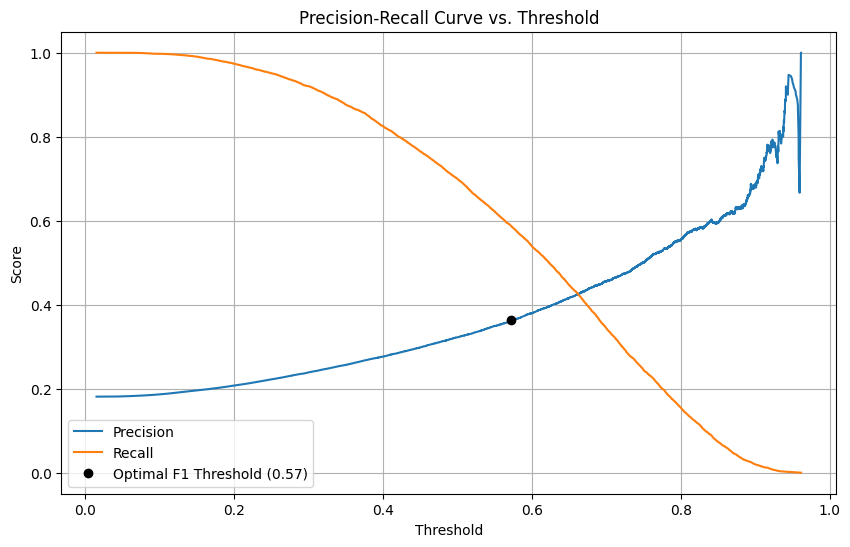

In [14]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# 1. Tính toán Precision, Recall và các ngưỡng tương ứng
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# 2. Tìm ngưỡng tối ưu (Ví dụ: Ngưỡng tối ưu hóa F1-Score)
# Thường sẽ tìm ngưỡng tối đa hóa F1-Score, hoặc cân bằng Precision/Recall
# Ngưỡng tối đa hóa F1:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore) #find the index in the fscore array where F1-score is maximized
optimal_threshold_f1 = thresholds[ix] #xuất ra giá trị ngưỡng của F1-score

print(f"Ngưỡng Tối ưu hóa F1-Score: {optimal_threshold_f1:.4f}")
print(f"Precision tại ngưỡng này: {precision[ix]:.4f}")
print(f"Recall tại ngưỡng này: {recall[ix]:.4f}")

# 3. Vẽ đường cong Precision-Recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(optimal_threshold_f1, precision[ix], 'o', color='black', label=f'Optimal F1 Threshold ({optimal_threshold_f1:.2f})')
plt.title('Precision-Recall Curve vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

TH1: Chọn threshold khi F1 max -> Cân bằng giữa Precision và Recall

Th2: Đảm bảo Precision tối thiểu: kéo precision lên 50%, chấp nhận lãng phí 50% tài nguyên

TH3: tăng recall lên tối thiểu 80% -> giảm threshold


In [15]:
# Ví dụ: Sử dụng ngưỡng tối ưu F1 (hoặc ngưỡng do bạn chọn)
new_threshold = optimal_threshold_f1 # Lấy ngưỡng đã tính toán

# Tạo nhãn dự đoán mới
y_pred_tuned = (y_prob >= new_threshold).astype(int)

# Đánh giá lại mô hình với ngưỡng mới
print("--- Đánh giá lại với Ngưỡng Mới ---")
print(classification_report(y_test, y_pred_tuned))

--- Đánh giá lại với Ngưỡng Mới ---
              precision    recall  f1-score   support

           0       0.89      0.77      0.83     39921
           1       0.36      0.59      0.45      8837

    accuracy                           0.74     48758
   macro avg       0.63      0.68      0.64     48758
weighted avg       0.80      0.74      0.76     48758



Nhưng sau tinh chỉnh thì kết quả không khả thi, recall giảm 0,11; precision tăng 0,04.

kq: giảm lãng phí (giảm FP) nhưng đồng thời bỏ sót nhiều khách hàng Churn hơn (tăng FN).
-> mô hình chưa tối ưu



# TRIỂN KHAI RANDOM FOREST

Bắt đầu huấn luyện Random Forest
Huấn luyện hoàn tất.
              precision    recall  f1-score   support

           0       0.90      0.70      0.79     39921
           1       0.33      0.65      0.44      8837

    accuracy                           0.69     48758
   macro avg       0.61      0.68      0.61     48758
weighted avg       0.80      0.69      0.73     48758


Random Forest AUC-ROC: 0.7468


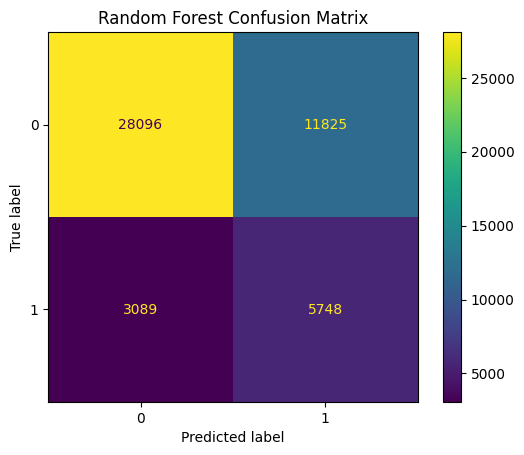

In [19]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Khởi tạo mô hình Random Forest
# Chúng ta sẽ sử dụng các tham số ban đầu để có một mô hình baseline mạnh mẽ
rf_model = RandomForestClassifier(
    n_estimators=200,          # Số lượng cây quyết định (tăng để cải thiện hiệu suất)
    max_depth=10,              # Chiều sâu tối đa của cây
    min_samples_leaf=5,        # Ngăn cây quá chuyên biệt vào dữ liệu huấn luyện
    random_state=42,
    class_weight='balanced'    # Rất quan trọng để xử lý mất cân bằng lớp
)

print("Bắt đầu huấn luyện Random Forest")
# Huấn luyện mô hình trên dữ liệu đã qua tiền xử lý
rf_model.fit(X_train_processed, y_train)
print("Huấn luyện hoàn tất.")

#Dự đoán trên T_T kiểm thử
y_pred_rf = rf_model.predict(X_test_processed)

#Lấy xác suất của lớp Churn
y_prob_rf = rf_model.predict_proba(X_test_processed)[:, 1]

#KQ
print(classification_report(y_test, y_pred_rf))

# Điểm AUC-ROC
auc_roc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"\nRandom Forest AUC-ROC: {auc_roc_rf:.4f}")

# Hiển thị Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=[0, 1])
disp_rf.plot()
plt.title("Random Forest Confusion Matrix")
plt.show()